# Age of Empires II Voobly Matches Data Exploration

## Load libraries and set options/environment

In [2]:
# System
import sys
import os
import datetime
from datetime import date, timedelta
sys.path.append('C:/Users/Parikshit_verma/Documents/GitHub/AgeofEmpires2_Voobly/src/functions')

# Custom functions
from setup_sql_conn import setup_sql_conn,fetch_sql_data
from sql_read import sql_read

# Data Wrangling
import pandas as pd
import numpy as np
import re
from functools import reduce
from pandas_profiling import ProfileReport

# Visualization
import seaborn as sb
import matplotlib.pyplot as plt
import plotly

# Set options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Read Data

In [114]:
db_conn,db_cursor,engine = setup_sql_conn('localhost','AOE2_VOOBLY')
match_data = sql_read('C:/Users/Parikshit_verma/Documents/GitHub/AgeofEmpires2_Voobly/Input/match_data_query.sql',db_conn)

Time taken to read from server : 4.4149558544158936


In [119]:
match_data

,Match_ID,Match_date,Match_time,Match_map,Match_length,Match_mod,Player,Points,Civilization,Victory,Military_Score,Economy_Score,Technology_Score,Society_Score,Total_Score,Units_Killed,Units_Lost,Buildings_Razed,Buildings_Lost,Units_Converted,Food,Wood,Stone,Gold,Feudal_Time,Castle_Time,Imperial_Time,Map_Explored,Research_Count,Research_Percent,Total_Wonders,Total_Castles,Relics_Captured,Relic_Gold,Villager_High,Player_Rating,Military_Score_diff,Economy_Score_diff,Technology_Score_diff,Society_Score_diff,Total_Score_diff,Units_Killed_diff,Units_Lost_diff,Buildings_Razed_diff,Buildings_Lost_diff,Units_Converted_diff,Food_diff,Wood_diff,Stone_diff,Gold_diff,Map_Explored_diff,Research_Count_diff,Research_Percent_diff,Total_Wonders_diff,Total_Castles_diff,Relics_Captured_diff,Relic_Gold_diff,Villager_High_diff,Player_Rating_diff
0,20850764,2019-11-02,20,Black Forest,12,v1.5 RC | Longer Lasting Resou,yuriiarabchuk,-4,Celts,0,0,301,1010,0,1311,0,2,0,0,0,1278,0,0,0,None,None,None,1.00,1,0.01,0,0,0,0,8,1387,-20,-292,-100,0,-412,-2,2,0,0,0,-1064,-634,-250,0,0.00,-2,-0.02,0,0,0,0,-16,-307
1,20850764,2019-11-02,20,Black Forest,12,v1.5 RC | Longer Lasting Resou,callemelilla,4,Franks,1,20,593,1110,0,1723,2,0,0,0,0,2342,634,250,0,11,None,None,1.00,3,0.03,0,0,0,0,24,1694,20,292,100,0,412,2,-2,0,0,0,1064,634,250,0,0.00,2,0.02,0,0,0,0,16,307
2,20394127,2019-08-17,0,Arabia,6,v1.5 RC | WololoKingdoms,[AML]MiguelBayona,-17,Goths,0,0,295,190,0,485,0,1,0,0,0,374,280,0,0,None,None,None,0.18,1,0.00,0,0,0,0,14,1268,-16,9,-60,0,-67,-1,1,0,0,0,-38,15,0,0,-0.06,0,0.00,0,0,0,0,1,32
3,20394127,2019-08-17,0,Arabia,6,v1.5 RC | WololoKingdoms,Tucoten,17,Franks,1,16,286,250,0,552,1,0,0,0,0,412,265,0,0,None,None,None,0.24,1,0.00,0,0,0,0,13,1236,16,-9,60,0,67,1,-1,0,0,0,38,-15,0,0,0.06,0,0.00,0,0,0,0,-1,-32
4,20394168,2019-08-17,0,Arabia,9,v1.5 RC | WololoKingdoms,Kensema,-22,Magyars,0,0,411,280,0,691,0,2,0,0,0,1098,371,0,0,None,None,None,0.27,1,0.00,0,0,0,0,21,1394,-16,-24,-60,0,-100,-1,2,0,0,0,-1,-131,0,0,-0.06,0,0.00,0,0,0,0,1,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99903,21115118,2019-12-29,2,Arabia,44,v1.5 RC,karvjuegos,-11,Turks,0,278,2551,1960,390,5179,15,85,1,14,2,11743,11690,2549,6307,11,20,None,0.84,21,0.20,0,3,0,0,94,1408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0
99904,21125959,2019-12-31,15,Arabia,69,v1.5 RC | WololoKingdoms,[NHN]CuLuNGueLe,-18,Khmer,0,6193,3055,1738,780,11766,313,247,28,32,4,19708,19030,5791,12125,9,25,None,0.56,25,0.16,11,6,0,0,97,1799,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0
99905,21139404,2020-01-03,19,Arabia,57,v1.5 RC | WololoKingdoms,['FNX_]GeafArgento,-14,Goths,0,2566,3524,1544,650,8284,145,220,9,15,5,17764,17167,4891,8023,10,29,None,0.63,22,0.15,6,5,0,0,135,1733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0
99906,21217342,2020-01-22,1,Arabia,60,v1.5 RC | WololoKingdoms,WhoCl,-19,Goths,0,4553,2515,1481,390,8939,199,244,1,14,7,16471,16844,3149,5374,9,27,None,0.61,20,0.13,1,3,0,0,101,2070,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0,0,0


## Data Mining & Profiling

In [115]:
# Match data cleanup
# Civilization dictionary
civ_map = ['Aztecs','Berbers','Britons','Bulgarians','Burmese','Byzantines','Celts','Chinese','Cumans','Ethiopians','Franks','Goths','Huns','Incas','Indians'
            ,'Italians','Japanese','Khmer','Koreans','Lithuanians','Magyars','Malay','Malians','Mayans','Mongols','Persians','Portuguese','Saracens','Slavs'
            ,'Spanish','Tatars','Teutons','Turks','Vietnamese','Vikings']
civ_map = {i.upper()[0:3] : i for i in civ_map}

match_data = (match_data
              .assign(Player_Rating = match_data['New_Rating'] - match_data['Points'],
                      Civilization = match_data['Civilization'].map(civ_map),
                      Match_date = pd.to_datetime(match_data['Match_date']),
                      Match_time = pd.to_datetime(match_data['Match_time'], format='%H:%M:%S').dt.hour)
              .drop(['Match_rating','Match_player_no','New_Rating','ladder',
                     'Trade_Profit','Tribute_Received','Tribute_Sent',
                     'Team'],axis=1)
              .dropna(subset=['Civilization']))

In [116]:
# Create differenced scores and stats
match_data_max = (match_data
                  .groupby(['Match_ID'])['Military_Score','Economy_Score','Technology_Score','Society_Score','Total_Score',
                                         'Units_Killed','Units_Lost','Buildings_Razed','Buildings_Lost','Units_Converted',
                                         'Food','Wood','Stone','Gold',
                                         'Map_Explored','Research_Count','Research_Percent',
                                         'Total_Wonders','Total_Castles','Relics_Captured','Relic_Gold','Villager_High',
                                         'Player_Rating'].max()
                  .add_suffix('_max')).reset_index()

match_data_min = (match_data
                  .groupby(['Match_ID'])['Military_Score','Economy_Score','Technology_Score','Society_Score','Total_Score',
                                         'Units_Killed','Units_Lost','Buildings_Razed','Buildings_Lost','Units_Converted',
                                         'Food','Wood','Stone','Gold',
                                         'Map_Explored','Research_Count','Research_Percent',
                                         'Total_Wonders','Total_Castles','Relics_Captured','Relic_Gold','Villager_High',
                                         'Player_Rating'].min()
                  .add_suffix('_min')).reset_index()

match_data = (match_data
              .merge(match_data_max,on = 'Match_ID')
              .merge(match_data_min,on = 'Match_ID'))

match_data = (match_data
              .assign(Military_Score_diff = np.where(match_data['Military_Score'] == match_data['Military_Score_max'], 
                                                     match_data['Military_Score'] - match_data['Military_Score_min'], 
                                                     match_data['Military_Score'] - match_data['Military_Score_max']),
                      Economy_Score_diff = np.where(match_data['Economy_Score'] == match_data['Economy_Score_max'], 
                                                    match_data['Economy_Score'] - match_data['Economy_Score_min'], 
                                                    match_data['Economy_Score'] - match_data['Economy_Score_max']),
                      Technology_Score_diff = np.where(match_data['Technology_Score'] == match_data['Technology_Score_max'], 
                                                       match_data['Technology_Score'] - match_data['Technology_Score_min'], 
                                                       match_data['Technology_Score'] - match_data['Technology_Score_max']),
                      Society_Score_diff = np.where(match_data['Society_Score'] == match_data['Society_Score_max'], 
                                                    match_data['Society_Score'] - match_data['Society_Score_min'], 
                                                    match_data['Society_Score'] - match_data['Society_Score_max']),
                      Total_Score_diff = np.where(match_data['Total_Score'] == match_data['Total_Score_max'], 
                                                  match_data['Total_Score'] - match_data['Total_Score_min'], 
                                                  match_data['Total_Score'] - match_data['Total_Score_max']),
                      Units_Killed_diff = np.where(match_data['Units_Killed'] == match_data['Units_Killed_max'], 
                                                   match_data['Units_Killed'] - match_data['Units_Killed_min'], 
                                                   match_data['Units_Killed'] - match_data['Units_Killed_max']),
                      Units_Lost_diff = np.where(match_data['Units_Lost'] == match_data['Units_Lost_max'], 
                                                 match_data['Units_Lost'] - match_data['Units_Lost_min'], 
                                                 match_data['Units_Lost'] - match_data['Units_Lost_max']),
                      Buildings_Razed_diff = np.where(match_data['Buildings_Razed'] == match_data['Buildings_Razed_max'], 
                                                      match_data['Buildings_Razed'] - match_data['Buildings_Razed_min'], 
                                                      match_data['Buildings_Razed'] - match_data['Buildings_Razed_max']),
                      Buildings_Lost_diff = np.where(match_data['Buildings_Lost'] == match_data['Buildings_Lost_max'], 
                                                     match_data['Buildings_Lost'] - match_data['Buildings_Lost_min'], 
                                                     match_data['Buildings_Lost'] - match_data['Buildings_Lost_max']),
                      Units_Converted_diff = np.where(match_data['Units_Converted'] == match_data['Units_Converted_max'], 
                                                      match_data['Units_Converted'] - match_data['Units_Converted_min'], 
                                                      match_data['Units_Converted'] - match_data['Units_Converted_max']),                      
                      Food_diff = np.where(match_data['Food'] == match_data['Food_max'], 
                                           match_data['Food'] - match_data['Food_min'], 
                                           match_data['Food'] - match_data['Food_max']),
                      Wood_diff = np.where(match_data['Wood'] == match_data['Wood_max'], 
                                           match_data['Wood'] - match_data['Wood_min'], 
                                           match_data['Wood'] - match_data['Wood_max']),
                      Stone_diff = np.where(match_data['Stone'] == match_data['Stone_max'], 
                                            match_data['Stone'] - match_data['Stone_min'], 
                                            match_data['Stone'] - match_data['Stone_max']),
                      Gold_diff = np.where(match_data['Gold'] == match_data['Gold_max'], 
                                           match_data['Gold'] - match_data['Gold_min'], 
                                           match_data['Gold'] - match_data['Gold_max']),                      
                      Map_Explored_diff = np.where(match_data['Map_Explored'] == match_data['Map_Explored_max'], 
                                                   match_data['Map_Explored'] - match_data['Map_Explored_min'], 
                                                   match_data['Map_Explored'] - match_data['Map_Explored_max']),
                      Research_Count_diff = np.where(match_data['Research_Count'] == match_data['Research_Count_max'], 
                                                     match_data['Research_Count'] - match_data['Research_Count_min'], 
                                                     match_data['Research_Count'] - match_data['Research_Count_max']),
                      Research_Percent_diff = np.where(match_data['Research_Percent'] == match_data['Research_Percent_max'], 
                                                       match_data['Research_Percent'] - match_data['Research_Percent_min'], 
                                                       match_data['Research_Percent'] - match_data['Research_Percent_max']),
                      Total_Wonders_diff = np.where(match_data['Total_Wonders'] == match_data['Total_Wonders_max'], 
                                                    match_data['Total_Wonders'] - match_data['Total_Wonders_min'], 
                                                    match_data['Total_Wonders'] - match_data['Total_Wonders_max']),                      
                      Total_Castles_diff = np.where(match_data['Total_Castles'] == match_data['Total_Castles_max'], 
                                                     match_data['Total_Castles'] - match_data['Total_Castles_min'], 
                                                     match_data['Total_Castles'] - match_data['Total_Castles_max']),
                      Relics_Captured_diff = np.where(match_data['Relics_Captured'] == match_data['Relics_Captured_max'], 
                                                     match_data['Relics_Captured'] - match_data['Relics_Captured_min'], 
                                                     match_data['Relics_Captured'] - match_data['Relics_Captured_max']),
                      Relic_Gold_diff = np.where(match_data['Relic_Gold'] == match_data['Relic_Gold_max'], 
                                                     match_data['Relic_Gold'] - match_data['Relic_Gold_min'], 
                                                     match_data['Relic_Gold'] - match_data['Relic_Gold_max']),
                      Villager_High_diff = np.where(match_data['Villager_High'] == match_data['Villager_High_max'], 
                                                     match_data['Villager_High'] - match_data['Villager_High_min'], 
                                                     match_data['Villager_High'] - match_data['Villager_High_max']),                      
                      Player_Rating_diff = np.where(match_data['Player_Rating'] == match_data['Player_Rating_max'], 
                                                     match_data['Player_Rating'] - match_data['Player_Rating_min'], 
                                                     match_data['Player_Rating'] - match_data['Player_Rating_max'])))

match_data = match_data[match_data.columns.drop(list(match_data.filter(regex='max')))]
match_data = match_data[match_data.columns.drop(list(match_data.filter(regex='min')))]

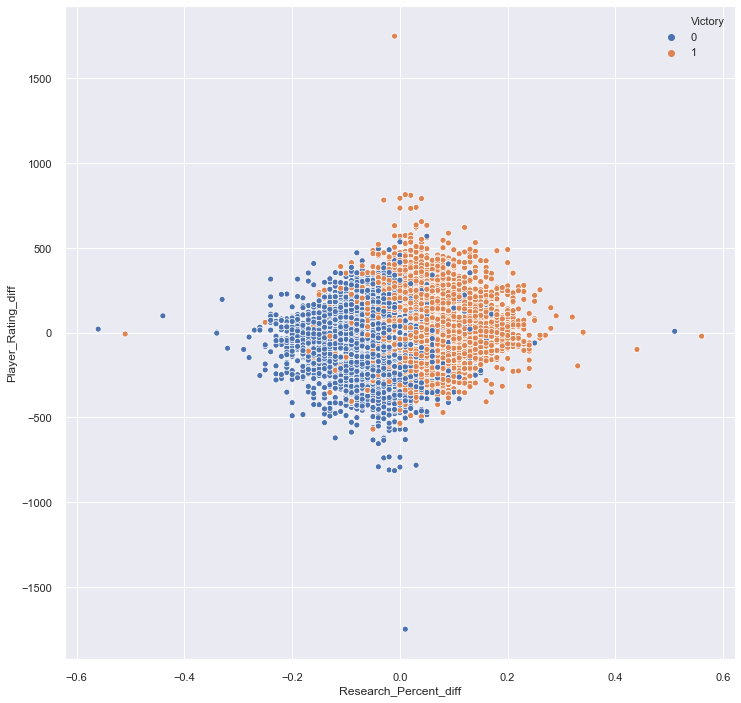

In [129]:
sb.set(rc={'figure.figsize':(12,12)})
ax = sb.scatterplot(x="Research_Percent_diff",y="Player_Rating_diff",data = match_data,hue="Victory")